In [1]:
import sys
sys.path.append('../') # 実行ディレクトリをrootとする
sys.path.append('../module/')
from module import models

import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

INPUT_PATH = '../input/'
OUTPUT_PATH = '../output/'

train = pd.read_csv(INPUT_PATH+'train.csv')
test = pd.read_csv(INPUT_PATH+'test.csv')

SEED=71

le = LabelEncoder()


train_y = train['genre']
train_feat_df = train.drop(['index','genre'], axis=1)
test_feat_df = test.drop(['index'], axis=1)

train_feat_df['tempo'] = train_feat_df['tempo'].map(lambda x : (int(x.split('-')[0])+int(x.split('-')[1]))/2) 
train_feat_df['region'] = le.fit_transform(train['region'])

test_feat_df['tempo'] = test_feat_df['tempo'].map(lambda x : (int(x.split('-')[0])+int(x.split('-')[1]))/2) 
test_feat_df['region'] = le.fit_transform(test['region'])

In [2]:
def make_cv(n_split, seed):
    fold = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=seed)
    return list(fold.split(train, train_y))


cv = make_cv(5, SEED)


params={'boosting_type': 'gbdt',
 'objective': 'multiclass',
 'metric': 'multi_logloss',
 'num_class': 11,
 #'feature_pre_filter': False,
 'lambda_l1': 1.8260943871703617,
 'lambda_l2': 8.704872539528923,
 'num_leaves': 17,
 'feature_fraction': 0.8999999999999999,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 10,
 'verbosity':-1,
 #'learning_rate':0.01
  #'force_col_wise':True
       }

model = models.Lgbm(params)

oof_preds_lgb, test_preds_lgb, evals_result_lgb = model.cv(train_y,
                                                         train_feat_df,
                                                         test_feat_df,
                                                         cv,
                                                        is_reg=False
#                                                           is_rmsle=False
                                                          )

Fold0_F1 : 0.45778703602791443
Fold1_F1 : 0.5227403985347452
Fold2_F1 : 0.5223628635714088
Fold3_F1 : 0.4946327012867288
Fold4_F1 : 0.5231688613997995
--------------------------------------------------
oof score : 0.5057685907858389
--------------------------------------------------


(<Figure size 864x288 with 1 Axes>,
 <AxesSubplot:xlabel='feature_importance', ylabel='column'>)

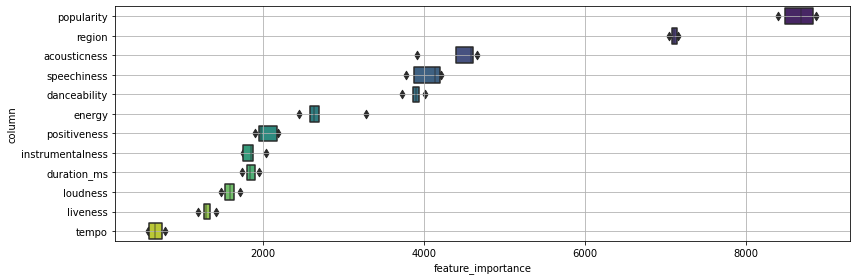

In [3]:
model.visualize_importance()

fold0:Acc 0.5114268066707844
fold1:Acc 0.5077208153180975
fold2:Acc 0.5105067985166872
fold3:Acc 0.4919653893695921
fold4:Acc 0.515451174289246
--------------------------------------------------
oof score : 0.5074147305981216


(<Figure size 864x288 with 1 Axes>,
 <AxesSubplot:xlabel='feature_importance', ylabel='column'>)

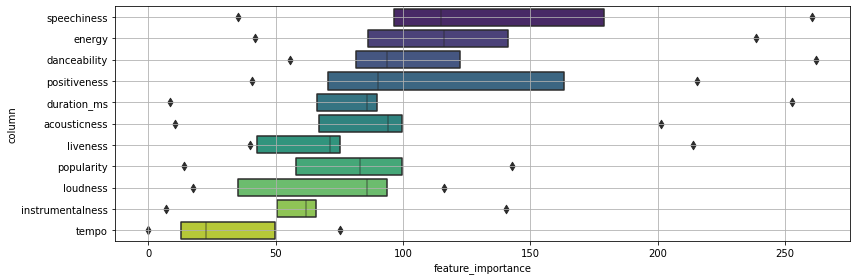

In [6]:
import models
params = {'boosting_type': 'gbdt',
          'objective': 'cross_entropy',
          'verbosity':-1}

model_ad = models.Lgbm(params)

# regionのfeature importanceだけ異常に高く、精度も0.6前後だったため、一度落としてみたらうまくいった
train_feat_df = train_feat_df.drop(['region'], axis=1)
test_feat_df = test_feat_df.drop(['region'], axis=1)

model_ad.adversal_validation(train_feat_df, test_feat_df)
model_ad.visualize_importance()